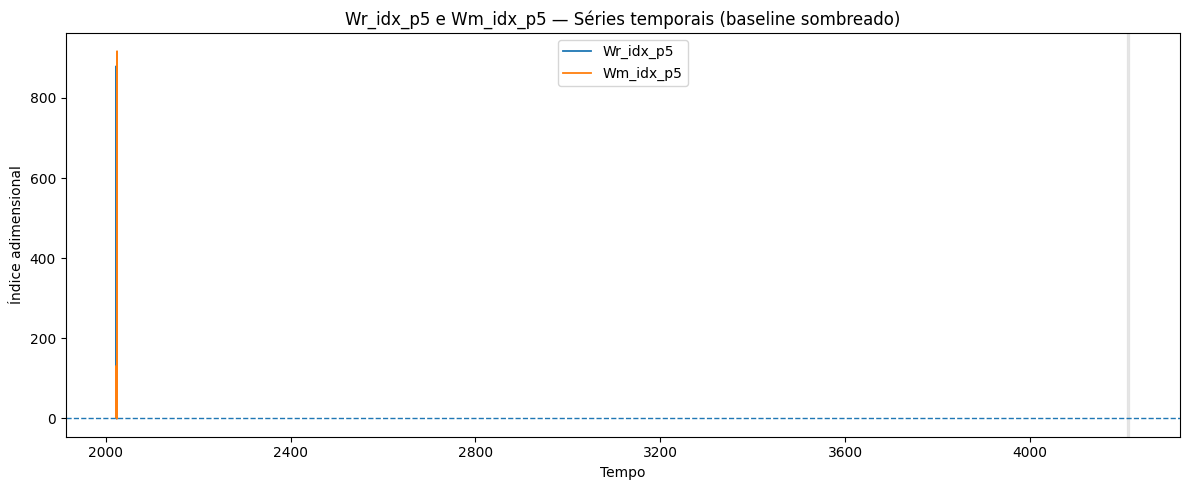

Figura salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\diagnosticos\lamina1_indices_timeline.png


In [4]:
# -*- coding: utf-8 -*-
# LÂMINA 1 — Séries temporais de Wr_idx_p5 e Wm_idx_p5 com baseline sombreado
# Dependências: pandas, numpy, matplotlib, python-dateutil

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser as dtparse

# ====== CONFIGURAÇÃO ======
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")
OUT_PNG    = os.path.join(BASE_DIR, r"outputs\diagnosticos\lamina1_indices_timeline.png")
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)

# Aliases de colunas
IDX_WR_ALIASES = ["wr_over_wrref", "wr_idx", "wr_idx_p5", "wr_wrref","wr/wrref"]
IDX_WM_ALIASES = ["wm_over_wmref", "wm_idx", "wm_idx_p5", "wm_wmref","wm/wmref"]
TS_ALIASES     = ["timestamp", "Timestamp", "datetime", "datahora", "date_time"]

# ====== FUNÇÕES ======
def first_match(cands, columns):
    cols_norm = [c.lower() for c in columns]
    for cand in cands:
        if cand.lower() in cols_norm:
            return columns[cols_norm.index(cand.lower())]
    for cand in cands:
        cnd = cand.lower()
        for i, c in enumerate(cols_norm):
            if cnd in c:
                return columns[i]
    return None

# ====== CARGA ======
df = pd.read_csv(DADOS_REF)
with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)

# timestamp
col_ts = first_match(TS_ALIASES, df.columns)
if col_ts is None:
    raise RuntimeError("Coluna de timestamp não encontrada no dados_ref.csv.")

df[col_ts] = pd.to_datetime(df[col_ts], errors="coerce")
df = df.sort_values(col_ts)

# índices
col_wr_idx = first_match(IDX_WR_ALIASES, df.columns)
col_wm_idx = first_match(IDX_WM_ALIASES, df.columns)
if col_wr_idx is None or col_wm_idx is None:
    raise RuntimeError("Colunas de índices (wr/wrref, wm/wmref) não encontradas no dados_ref.csv.")

# bounds do baseline no JSON (se existirem)
def find_period_bounds(d):
    def find_key(d, keys):
        if isinstance(d, dict):
            for k,v in d.items():
                if isinstance(k,str) and any(kk in k.lower() for kk in keys):
                    if isinstance(v,(str,int,float)):
                        try: return dtparse.parse(str(v))
                        except: pass
                if isinstance(v,(dict,list)):
                    r = find_key(v, keys)
                    if r: return r
        if isinstance(d,list):
            for it in d:
                r = find_key(it, keys)
                if r: return r
        return None
    t0 = find_key(d, ["start","inicio","t_start","t0","ini"])
    t1 = find_key(d, ["end","fim","t_end","t1","final"])
    return t0, t1

b0, b1 = find_period_bounds(ref)

# ====== PLOT ======
plt.figure(figsize=(12, 5))
plt.plot(df[col_ts], df[col_wr_idx], label="Wr_idx_p5", linewidth=1.3)
plt.plot(df[col_ts], df[col_wm_idx], label="Wm_idx_p5", linewidth=1.3)

# linha de referência 1.0
plt.axhline(1.0, linestyle="--", linewidth=1)

# baseline sombreado (se disponível)
if b0 and b1:
    plt.axvspan(b0, b1, color="gray", alpha=0.15)

plt.xlabel("Tempo")
plt.ylabel("Índice adimensional")
plt.title("Wr_idx_p5 e Wm_idx_p5 — Séries temporais (baseline sombreado)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=160)
plt.show()

print("Figura salva em:", OUT_PNG)


DIAGNÓSTICO: {'rows': 4636, 'ts_mode': 'parsed-string', 'wr/wrref_q': [0.0, 0.2864, 36.9554, 487.1603, 609.5924], 'wm/wmref_q': [0.0, 0.3951, 8.1733, 15.8011, 66.0823]}


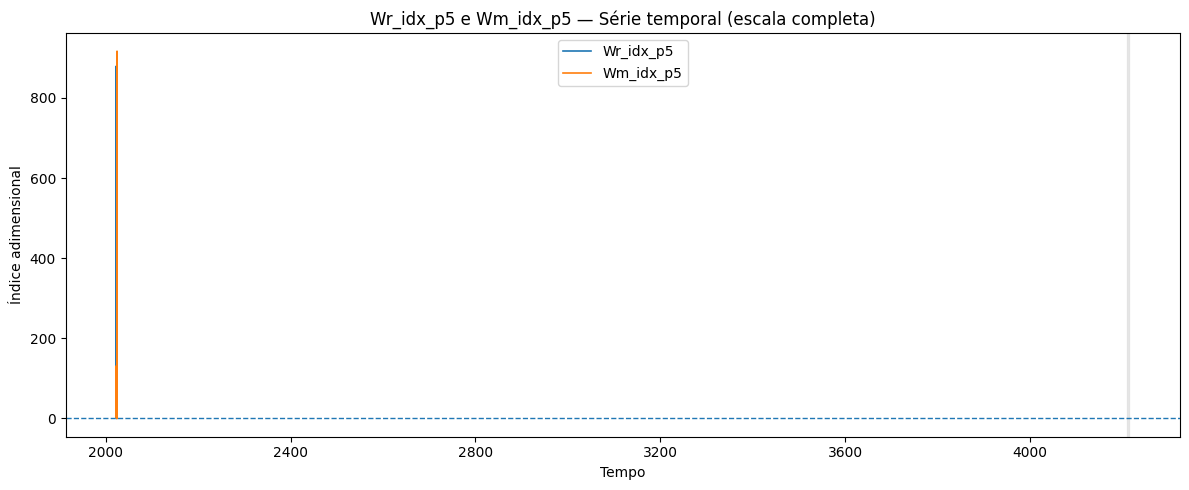

Figura (escala completa): C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\diagnosticos\lamina1_timeseries_full.png


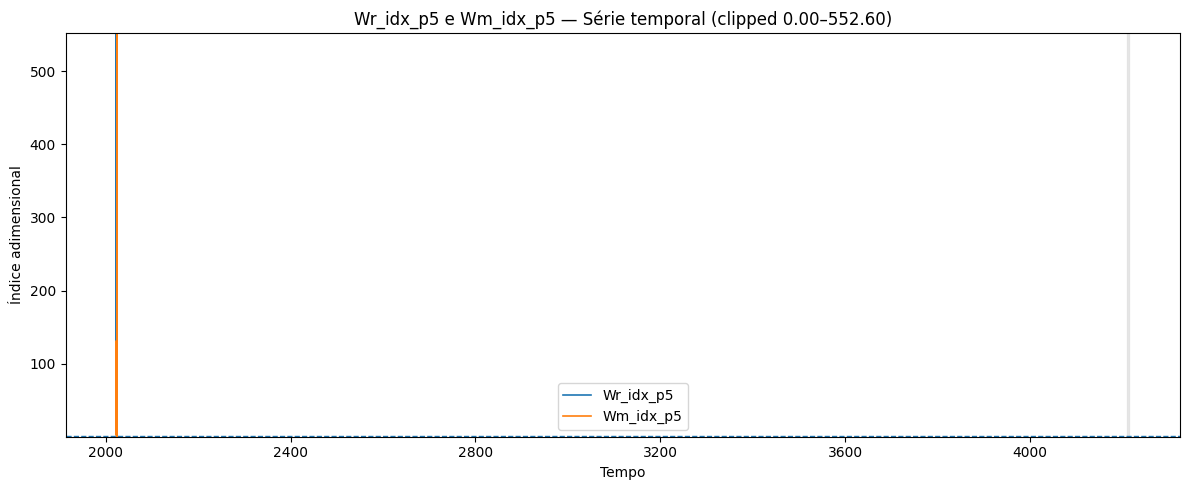

Figura (clipped): C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\diagnosticos\lamina1_timeseries_clipped.png

Top picos (para investigar):
                 ts    serie      valor
2024-09-29 14:00:00 wm/wmref 916.717938
2023-03-01 23:00:00 wr/wrref 879.517886
2023-03-01 19:00:00 wr/wrref 791.714859
2023-03-01 21:00:00 wr/wrref 748.627737
2023-03-05 00:00:00 wr/wrref 740.227407


In [5]:
# -*- coding: utf-8 -*-
# Lâmina 1 — robusto: timestamp "smart", índices por p5 do baseline, e gráfico com e sem clipping.

import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser as dtparse

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

OUT_DIR = os.path.join(BASE_DIR, r"outputs\diagnosticos"); os.makedirs(OUT_DIR, exist_ok=True)
OUT_FULL   = os.path.join(OUT_DIR, "lamina1_timeseries_full.png")
OUT_CLIPPED= os.path.join(OUT_DIR, "lamina1_timeseries_clipped.png")

# ===== HELPERS =====
def smart_parse_timestamp(s: pd.Series):
    """Tenta converter a coluna 'timestamp' em datetime. Se não conseguir, devolve um índice numérico."""
    # Se já é datetime
    if np.issubdtype(s.dtype, np.datetime64):
        return s, "datetime"
    # Se é string: tentar parse direto e, se precisar, dayfirst
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce", utc=False)
        if ts.notna().mean() > 0.8:
            return ts, "parsed-string"
        ts = pd.to_datetime(s, errors="coerce", utc=False, dayfirst=True)
        if ts.notna().mean() > 0.8:
            return ts, "parsed-string-dayfirst"
    # Se é numérico: heurísticas (epoch ms/s, excel days)
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        x = x[np.isfinite(x)]
        if x.empty:
            return pd.RangeIndex(len(s)), "index"
        xmin, xmax = float(x.min()), float(x.max())
        # excel days ~ 40k-50k
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.to_datetime("1899-12-30")  # origem Excel
            ts = base + pd.to_timedelta(pd.to_numeric(s, errors="coerce"), unit="D")
            return ts, "excel-days"
        # epoch ms (>1e12 típico para ns, >1e11~1e12 ms)
        if xmin > 1e11 and xmax < 1e15:
            ts = pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="ms", utc=False)
            return ts, "epoch-ms"
        # epoch s (1e9 ~ 2001-09-09)
        if 9e8 < xmin < 2e9 and 9e8 < xmax < 2e9:
            ts = pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="s", utc=False)
            return ts, "epoch-s"
    # fallback: índice
    return pd.RangeIndex(len(s)), "index"

def deep_find_number(d, keys):
    """Busca recursivamente um número em d cujas chaves combinem com 'keys'."""
    if isinstance(d, dict):
        for k, v in d.items():
            if isinstance(k, str) and any(kk in k.lower() for kk in keys) and isinstance(v, (int, float)):
                return float(v)
            val = deep_find_number(v, keys)
            if val is not None:
                return val
    elif isinstance(d, list):
        for it in d:
            val = deep_find_number(it, keys)
            if val is not None:
                return val
    return None

def find_period_bounds(d):
    def find_key(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys) and isinstance(v, (str, int, float)):
                    try: return dtparse.parse(str(v))
                    except: pass
                if isinstance(v, (dict, list)):
                    r = find_key(v, keys)
                    if r: return r
        elif isinstance(d, list):
            for it in d:
                r = find_key(it, keys)
                if r: return r
        return None
    t0 = find_key(d, ["start","inicio","t_start","t0","ini"])
    t1 = find_key(d, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== LOAD =====
df = pd.read_csv(DADOS_REF)

# Timestamp
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")
ts_parsed, ts_mode = smart_parse_timestamp(df["timestamp"])
df = df.assign(_ts=ts_parsed).sort_values("_ts")

# Índices: usar prontos se tiver; senão calcular por p5 do baseline (ou p5 global)
have_wridx = "wr/wrref" in df.columns
have_wmidx = "wm/wmref" in df.columns

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)

b0, b1 = find_period_bounds(ref)

def compute_refs_p5(slice_df):
    wr_ref = float(np.nanpercentile(slice_df["wr_kg_m2_h"], 5))
    wm_ref = float(np.nanpercentile(slice_df["wm_kg_m2_h"], 5))
    return wr_ref, wm_ref

ref_source = None
if not (have_wridx and have_wmidx):
    if "wr_kg_m2_h" not in df.columns or "wm_kg_m2_h" not in df.columns:
        raise RuntimeError("Sem índices prontos e sem 'wr_kg_m2_h'/'wm_kg_m2_h' para calcular.")
    # baseline -> p5
    if b0 and b1 and ts_mode != "index":
        mask = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
        ref_slice = df.loc[mask]
        if not ref_slice.empty:
            wr_ref, wm_ref = compute_refs_p5(ref_slice)
            ref_source = f"p5-baseline ({b0}–{b1})"
        else:
            wr_ref, wm_ref = compute_refs_p5(df)
            ref_source = "p5-global (baseline vazio)"
    else:
        wr_ref, wm_ref = compute_refs_p5(df)
        ref_source = "p5-global (sem baseline utilizável)"

    if not have_wridx:
        df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
    if not have_wmidx:
        df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# ===== DIAGNÓSTICO =====
wrr = df["wr/wrref"].replace([np.inf,-np.inf], np.nan)
wmr = df["wm/wmref"].replace([np.inf,-np.inf], np.nan)

diag = {
    "rows": len(df),
    "ts_mode": ts_mode,
    "wr/wrref_q": np.nanpercentile(wrr, [0, 5, 50, 95, 99.5]).round(4).tolist(),
    "wm/wmref_q": np.nanpercentile(wmr, [0, 5, 50, 95, 99.5]).round(4).tolist(),
}
if ref_source:
    diag["ref_source"] = ref_source

print("DIAGNÓSTICO:", diag)

# ===== PLOT (ESCALA COMPLETA) =====
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df["_ts"], wrr, label="Wr_idx_p5", linewidth=1.2)
ax.plot(df["_ts"], wmr, label="Wm_idx_p5", linewidth=1.2)
ax.axhline(1.0, linestyle="--", linewidth=1)
if b0 and b1 and ts_mode != "index":
    ax.axvspan(b0, b1, color="gray", alpha=0.15)
ax.set_xlabel("Tempo" if ts_mode != "index" else "Amostra")
ax.set_ylabel("Índice adimensional")
ax.set_title("Wr_idx_p5 e Wm_idx_p5 — Série temporal (escala completa)")
ax.legend()
fig.tight_layout()
fig.savefig(OUT_FULL, dpi=160)
plt.show()
print("Figura (escala completa):", OUT_FULL)

# ===== PLOT (CLIPPED 0.5%–99.5%) =====
ymin = float(np.nanpercentile(np.r_[wrr, wmr], 0.5))
ymax = float(np.nanpercentile(np.r_[wrr, wmr], 99.5))
if np.isfinite(ymin) and np.isfinite(ymax) and ymin < ymax:
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df["_ts"], wrr, label="Wr_idx_p5", linewidth=1.2)
    ax.plot(df["_ts"], wmr, label="Wm_idx_p5", linewidth=1.2)
    ax.axhline(1.0, linestyle="--", linewidth=1)
    if b0 and b1 and ts_mode != "index":
        ax.axvspan(b0, b1, color="gray", alpha=0.15)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Tempo" if ts_mode != "index" else "Amostra")
    ax.set_ylabel("Índice adimensional")
    ax.set_title(f"Wr_idx_p5 e Wm_idx_p5 — Série temporal (clipped {ymin:.2f}–{ymax:.2f})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUT_CLIPPED, dpi=160)
    plt.show()
    print("Figura (clipped):", OUT_CLIPPED)
else:
    print("Aviso: não foi possível determinar limites robustos para clipping.")

# (Opcional) Mostrar top-5 picos para investigação
top_n = 5
peaks = (
    pd.DataFrame({"ts": df["_ts"], "wr/wrref": wrr, "wm/wmref": wmr})
      .melt(id_vars="ts", var_name="serie", value_name="valor")
      .sort_values("valor", ascending=False)
      .head(top_n)
)
print("\nTop picos (para investigar):")
print(peaks.to_string(index=False))


In [7]:
# -*- coding: utf-8 -*-
# LÂMINA 1 — Gráfico 2 (interativo): séries de wr/wrref e wm/wmref
# com zoom/pan, range slider e botões para ajustar o range do eixo Y.
# Se os índices não existirem no CSV, calcula a partir de wr_kg_m2_h/wm_kg_m2_h
# usando p5 do baseline (JSON) ou p5 global.

%pip install plotly

import os, json
import numpy as np
import pandas as pd
from dateutil import parser as dtparse

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

# ===== HELPERS =====
def smart_parse_timestamp(s: pd.Series):
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        if x.notna().sum() == 0: return pd.RangeIndex(len(s))
        xmin, xmax = float(x.min()), float(x.max())
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.to_datetime("1899-12-30")
            return base + pd.to_timedelta(pd.to_numeric(s, errors="coerce"), unit="D")
        if xmin > 1e11 and xmax < 1e15:
            return pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="ms")
        if 9e8 < xmin < 2e9:
            return pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="s")
    return pd.RangeIndex(len(s))

def find_period_bounds(d):
    def find_key(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys) and isinstance(v,(str,int,float)):
                    try: return dtparse.parse(str(v))
                    except: pass
                if isinstance(v, (dict,list)):
                    r = find_key(v, keys)
                    if r: return r
        elif isinstance(d, list):
            for it in d:
                r = find_key(it, keys)
                if r: return r
        return None
    t0 = find_key(d, ["start","inicio","t_start","t0","ini"])
    t1 = find_key(d, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== LOAD & PREP =====
df = pd.read_csv(DADOS_REF)

if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")
df["_ts"] = smart_parse_timestamp(df["timestamp"])
df = df.sort_values("_ts")

have_wridx = "wr/wrref" in df.columns
have_wmidx = "wm/wmref" in df.columns

# calcular índices se necessário
with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds(ref)

def compute_refs_p5(slice_df):
    wr_ref = float(np.nanpercentile(slice_df["wr_kg_m2_h"], 5))
    wm_ref = float(np.nanpercentile(slice_df["wm_kg_m2_h"], 5))
    return wr_ref, wm_ref

if not (have_wridx and have_wmidx):
    if "wr_kg_m2_h" not in df.columns or "wm_kg_m2_h" not in df.columns:
        raise RuntimeError("Sem 'wr/wrref'/'wm/wmref' e sem 'wr_kg_m2_h'/'wm_kg_m2_h' para calcular.")
    if pd.api.types.is_datetime64_any_dtype(df["_ts"]) and b0 and b1:
        mask = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
        ref_slice = df.loc[mask] if mask.any() else df
    else:
        ref_slice = df
    wr_ref, wm_ref = compute_refs_p5(ref_slice)
    if not have_wridx:
        df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
    if not have_wmidx:
        df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# séries tratadas
wrr = df["wr/wrref"].replace([np.inf,-np.inf], np.nan)
wmr = df["wm/wmref"].replace([np.inf,-np.inf], np.nan)

# percentis para botões de escala
allv = np.r_[wrr.values, wmr.values]
p995_low, p995_high = np.nanpercentile(allv, [0.5, 99.5])
p95_low,  p95_high  = np.nanpercentile(allv, [2.5, 97.5])

# ===== FIGURA INTERATIVA (PLOTLY) =====
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=df["_ts"], y=wrr, name="Wr_idx_p5", mode="lines"))
fig.add_trace(go.Scatter(x=df["_ts"], y=wmr, name="Wm_idx_p5", mode="lines"))
fig.add_hline(y=1.0, line_dash="dash", opacity=0.6)

# sombrear baseline (se houver datas reais)
if pd.api.types.is_datetime64_any_dtype(df["_ts"]) and b0 and b1:
    fig.add_vrect(x0=b0, x1=b1, fillcolor="gray", opacity=0.15, line_width=0)

fig.update_layout(
    title="Wr_idx_p5 e Wm_idx_p5 — Série temporal (interativo)",
    xaxis_title="Tempo" if pd.api.types.is_datetime64_any_dtype(df["_ts"]) else "Amostra",
    yaxis_title="Índice adimensional",
    hovermode="x unified",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Range slider + range selector
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
    buttons=list([
        dict(count=1, label="1h", step="hour", stepmode="backward"),
        dict(count=6, label="6h", step="hour", stepmode="backward"),
        dict(count=1, label="1d", step="day",  stepmode="backward"),
        dict(step="all", label="Tudo")
    ])
))

# Botões para Y-range (auto / p95 / p99.5 / reset)
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        direction="right",
        x=1, xanchor="right", y=1.12, yanchor="top",
        buttons=[
            dict(label="Auto", method="relayout",
                 args=[{"yaxis.autorange": True}]),
            dict(label="Clip 95%", method="relayout",
                 args=[{"yaxis.range": [float(p95_low), float(p95_high)],
                        "yaxis.autorange": False}]),
            dict(label="Clip 99.5%", method="relayout",
                 args=[{"yaxis.range": [float(p995_low), float(p995_high)],
                        "yaxis.autorange": False}]),
            dict(label="Reset", method="relayout",
                 args=[{"yaxis.range": None, "yaxis.autorange": True}]),
        ],
    )]
)

fig.show()


  Using cached plotly-6.3.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.1.2-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.3.0-py3-none-any.whl (9.8 MB)
Using cached narwhals-2.1.2-py3-none-any.whl (392 kB)

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   -------------------- ------------------- 1/2 [plotly]
   ------------

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [1]:
# -*- coding: utf-8 -*-
# LÂMINA 1 — Gráfico 2 (interativo, completo)
# - Zoom/pan, range slider, range selector
# - Botões: Auto / Clip 95% / Clip 99.5% (Y-range)
# - Botões: Escala Linear / Log
# - Botões: RAW / CLIPPED 95% / CLIPPED 99.5% (mostra/oculta séries)
# - Opcional: exporta HTML interativo

import os, json
import numpy as np
import pandas as pd
from dateutil import parser as dtparse
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")
OUT_HTML   = os.path.join(BASE_DIR, r"outputs\diagnosticos\lamina1_interativo.html")
os.makedirs(os.path.dirname(OUT_HTML), exist_ok=True)

# ===== HELPERS =====
def smart_parse_timestamp(s: pd.Series):
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        if x.notna().sum() == 0: return pd.RangeIndex(len(s))
        xmin, xmax = float(x.min()), float(x.max())
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.to_datetime("1899-12-30")
            return base + pd.to_timedelta(pd.to_numeric(s, errors="coerce"), unit="D")
        if xmin > 1e11 and xmax < 1e15:
            return pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="ms")
        if 9e8 < xmin < 2e9:
            return pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="s")
    return pd.RangeIndex(len(s))

def find_period_bounds(d):
    def find_key(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys) and isinstance(v,(str,int,float)):
                    try: return dtparse.parse(str(v))
                    except: pass
                if isinstance(v, (dict,list)):
                    r = find_key(v, keys)
                    if r: return r
        elif isinstance(d, list):
            for it in d:
                r = find_key(it, keys)
                if r: return r
        return None
    t0 = find_key(d, ["start","inicio","t_start","t0","ini"])
    t1 = find_key(d, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== LOAD & PREP =====
df = pd.read_csv(DADOS_REF)
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")
df["_ts"] = smart_parse_timestamp(df["timestamp"])
df = df.sort_values("_ts")

have_wridx = "wr/wrref" in df.columns
have_wmidx = "wm/wmref" in df.columns

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds(ref)

def compute_refs_p5(slice_df):
    wr_ref = float(np.nanpercentile(slice_df["wr_kg_m2_h"], 5))
    wm_ref = float(np.nanpercentile(slice_df["wm_kg_m2_h"], 5))
    return wr_ref, wm_ref

# Calcula índices se necessário
if not (have_wridx and have_wmidx):
    if "wr_kg_m2_h" not in df.columns or "wm_kg_m2_h" not in df.columns:
        raise RuntimeError("Sem 'wr/wrref'/'wm/wmref' e sem 'wr_kg_m2_h'/'wm_kg_m2_h' para calcular.")
    if pd.api.types.is_datetime64_any_dtype(df["_ts"]) and b0 and b1:
        mask = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
        ref_slice = df.loc[mask] if mask.any() else df
    else:
        ref_slice = df
    wr_ref, wm_ref = compute_refs_p5(ref_slice)
    if not have_wridx:
        df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
    if not have_wmidx:
        df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# Séries (raw) e versões clippadas
wrr_raw = df["wr/wrref"].replace([np.inf,-np.inf], np.nan)
wmr_raw = df["wm/wmref"].replace([np.inf,-np.inf], np.nan)

allv = np.r_[wrr_raw.values, wmr_raw.values]
p95_low,  p95_high  = np.nanpercentile(allv, [2.5, 97.5])
p995_low, p995_high = np.nanpercentile(allv, [0.5, 99.5])

wrr_c95 = wrr_raw.clip(lower=p95_low,  upper=p95_high)
wmr_c95 = wmr_raw.clip(lower=p95_low,  upper=p95_high)
wrr_c995= wrr_raw.clip(lower=p995_low, upper=p995_high)
wmr_c995= wmr_raw.clip(lower=p995_low, upper=p995_high)

# ===== FIGURA =====
fig = make_subplots(specs=[[{"secondary_y": False}]])

# RAW
tr_wr_raw = go.Scatter(x=df["_ts"], y=wrr_raw, name="Wr_idx_p5 (RAW)", mode="lines", visible=True,
                       hovertemplate="Wr_idx_p5=%{y:.3f}<br>%{x}<extra></extra>")
tr_wm_raw = go.Scatter(x=df["_ts"], y=wmr_raw, name="Wm_idx_p5 (RAW)", mode="lines", visible=True,
                       hovertemplate="Wm_idx_p5=%{y:.3f}<br>%{x}<extra></extra>")

# CLIPPED 95%
tr_wr_c95 = go.Scatter(x=df["_ts"], y=wrr_c95, name="Wr_idx_p5 (CLIP 95%)", mode="lines", visible=False,
                       hovertemplate="Wr_idx_p5=%{y:.3f}<br>%{x}<extra></extra>")
tr_wm_c95 = go.Scatter(x=df["_ts"], y=wmr_c95, name="Wm_idx_p5 (CLIP 95%)", mode="lines", visible=False,
                       hovertemplate="Wm_idx_p5=%{y:.3f}<br>%{x}<extra></extra>")

# CLIPPED 99.5%
tr_wr_c995 = go.Scatter(x=df["_ts"], y=wrr_c995, name="Wr_idx_p5 (CLIP 99.5%)", mode="lines", visible=False,
                        hovertemplate="Wr_idx_p5=%{y:.3f}<br>%{x}<extra></extra>")
tr_wm_c995 = go.Scatter(x=df["_ts"], y=wmr_c995, name="Wm_idx_p5 (CLIP 99.5%)", mode="lines", visible=False,
                        hovertemplate="Wm_idx_p5=%{y:.3f}<br>%{x}<extra></extra>")

fig.add_traces([tr_wr_raw, tr_wm_raw, tr_wr_c95, tr_wm_c95, tr_wr_c995, tr_wm_c995])
fig.add_hline(y=1.0, line_dash="dash", opacity=0.6)

# baseline
if pd.api.types.is_datetime64_any_dtype(df["_ts"]) and b0 and b1:
    fig.add_vrect(x0=b0, x1=b1, fillcolor="gray", opacity=0.15, line_width=0)

fig.update_layout(
    title="Wr_idx_p5 e Wm_idx_p5 — Série temporal (interativo)",
    xaxis_title="Tempo" if pd.api.types.is_datetime64_any_dtype(df["_ts"]) else "Amostra",
    yaxis_title="Índice adimensional",
    hovermode="x unified",
    xaxis=dict(showspikes=True, spikemode="across", spikesnap="cursor"),
    yaxis=dict(showspikes=True, spikemode="toaxis", spikesnap="cursor"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Range slider + range selector
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
    buttons=list([
        dict(count=1, label="1h", step="hour", stepmode="backward"),
        dict(count=6, label="6h", step="hour", stepmode="backward"),
        dict(count=1, label="1d", step="day",  stepmode="backward"),
        dict(step="all", label="Tudo")
    ])
))

# ---- Menus de controle ----
# 1) Botões para mostrar RAW / CLIP 95% / CLIP 99.5%
def vis_mask(raw=True, c95=False, c995=False):
    # ordem: [wr_raw, wm_raw, wr_c95, wm_c95, wr_c995, wm_c995]
    return [raw, raw, c95, c95, c995, c995]

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons", direction="right",
            x=1, xanchor="right", y=1.15, yanchor="top",
            buttons=[
                dict(label="RAW", method="update",
                     args=[{"visible": vis_mask(raw=True, c95=False, c995=False)}]),
                dict(label="CLIP 95%", method="update",
                     args=[{"visible": vis_mask(raw=False, c95=True, c995=False)}]),
                dict(label="CLIP 99.5%", method="update",
                     args=[{"visible": vis_mask(raw=False, c95=False, c995=True)}]),
            ],
            showactive=True
        ),
        dict(
            type="buttons", direction="right",
            x=1, xanchor="right", y=1.08, yanchor="top",
            buttons=[
                dict(label="Y Auto", method="relayout",
                     args=[{"yaxis.autorange": True}]),
                dict(label="Y Clip 95%", method="relayout",
                     args=[{"yaxis.range": [float(p95_low), float(p95_high)],
                            "yaxis.autorange": False}]),
                dict(label="Y Clip 99.5%", method="relayout",
                     args=[{"yaxis.range": [float(p995_low), float(p995_high)],
                            "yaxis.autorange": False}]),
                dict(label="Reset Y", method="relayout",
                     args=[{"yaxis.range": None, "yaxis.autorange": True}]),
            ],
            showactive=False
        ),
        dict(
            type="buttons", direction="right",
            x=1, xanchor="right", y=1.01, yanchor="top",
            buttons=[
                dict(label="Linear", method="relayout",
                     args=[{"yaxis.type": "linear"}]),
                dict(label="Log", method="relayout",
                     args=[{"yaxis.type": "log"}]),
            ],
            showactive=True
        ),
    ]
)

fig.show()

# (Opcional) salvar HTML interativo para compartilhar
try:
    fig.write_html(OUT_HTML, include_plotlyjs="cdn", full_html=True)
    print("Arquivo interativo salvo em:", OUT_HTML)
except Exception as e:
    print("Aviso ao salvar HTML:", e)


Arquivo interativo salvo em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\outputs\diagnosticos\lamina1_interativo.html


In [1]:
# -*- coding: utf-8 -*-
# LÂMINA 1 — Gráfico 2 (interativo) com:
# - X fixo 2018–2025
# - Slider contínuo de Y (ipywidgets), abaixo do gráfico
# - Botões de controle na margem inferior
# Requer: plotly, pandas, numpy, python-dateutil, ipywidgets (para o slider Y)

import os, json
import numpy as np
import pandas as pd
from dateutil import parser as dtparse
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

# ===== HELPERS =====
def smart_parse_timestamp(s: pd.Series):
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        if x.notna().sum() == 0: return pd.RangeIndex(len(s))
        xmin, xmax = float(x.min()), float(x.max())
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.to_datetime("1899-12-30")
            return base + pd.to_timedelta(pd.to_numeric(s, errors="coerce"), unit="D")
        if xmin > 1e11 and xmax < 1e15:
            return pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="ms")
        if 9e8 < xmin < 2e9:
            return pd.to_datetime(pd.to_numeric(s, errors="coerce"), unit="s")
    return pd.RangeIndex(len(s))

def find_period_bounds(d):
    def find_key(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys) and isinstance(v,(str,int,float)):
                    try: return dtparse.parse(str(v))
                    except: pass
                if isinstance(v, (dict,list)):
                    r = find_key(v, keys)
                    if r: return r
        elif isinstance(d, list):
            for it in d:
                r = find_key(it, keys)
                if r: return r
        return None
    t0 = find_key(d, ["start","inicio","t_start","t0","ini"])
    t1 = find_key(d, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== LOAD & PREP =====
df = pd.read_csv(DADOS_REF)
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")

df["_ts"] = smart_parse_timestamp(df["timestamp"])
df = df.sort_values("_ts")

have_wridx = "wr/wrref" in df.columns
have_wmidx = "wm/wmref" in df.columns

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds(ref)

def compute_refs_p5(slice_df):
    wr_ref = float(np.nanpercentile(slice_df["wr_kg_m2_h"], 5))
    wm_ref = float(np.nanpercentile(slice_df["wm_kg_m2_h"], 5))
    return wr_ref, wm_ref

# Calcula índices se necessário
if not (have_wridx and have_wmidx):
    if "wr_kg_m2_h" not in df.columns or "wm_kg_m2_h" not in df.columns:
        raise RuntimeError("Sem 'wr/wrref'/'wm/wmref' e sem 'wr_kg_m2_h'/'wm_kg_m2_h' para calcular.")
    if pd.api.types.is_datetime64_any_dtype(df["_ts"]) and b0 and b1:
        mask = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
        ref_slice = df.loc[mask] if mask.any() else df
    else:
        ref_slice = df
    wr_ref, wm_ref = compute_refs_p5(ref_slice)
    if not have_wridx:
        df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
    if not have_wmidx:
        df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# Séries (raw) e percentis
wrr_raw = df["wr/wrref"].replace([np.inf,-np.inf], np.nan)
wmr_raw = df["wm/wmref"].replace([np.inf,-np.inf], np.nan)
allv = np.r_[wrr_raw.values, wmr_raw.values]
p95_low,  p95_high  = np.nanpercentile(allv, [2.5, 97.5])
p995_low, p995_high = np.nanpercentile(allv, [0.5, 99.5])
min_v = float(np.nanmin(allv))
max_v = float(np.nanmax(allv))

# ===== FIGURA =====
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=df["_ts"], y=wrr_raw, name="Wr_idx_p5", mode="lines"))
fig.add_trace(go.Scatter(x=df["_ts"], y=wmr_raw, name="Wm_idx_p5", mode="lines"))
fig.add_hline(y=1.0, line_dash="dash", opacity=0.6)

# Baseline sombreado se datas reais
if pd.api.types.is_datetime64_any_dtype(df["_ts"]) and b0 and b1:
    fig.add_vrect(x0=b0, x1=b1, fillcolor="gray", opacity=0.15, line_width=0)

# Eixo X: fixo 2018–2025
x0_fixed = pd.Timestamp("2018-01-01")
x1_fixed = pd.Timestamp("2025-12-31")
fig.update_xaxes(range=[x0_fixed, x1_fixed], rangeslider_visible=True, rangeselector=dict(
    buttons=list([
        dict(count=1, label="1h", step="hour", stepmode="backward"),
        dict(count=6, label="6h", step="hour", stepmode="backward"),
        dict(count=1, label="1d", step="day",  stepmode="backward"),
        dict(step="all", label="Tudo")
    ])
))

fig.update_layout(
    title="Wr_idx_p5 e Wm_idx_p5 — Série temporal (interativo)",
    xaxis_title="Tempo",
    yaxis_title="Índice adimensional",
    hovermode="x unified",
    xaxis=dict(showspikes=True, spikemode="across", spikesnap="cursor"),
    yaxis=dict(showspikes=True, spikemode="toaxis", spikesnap="cursor"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# ----- Botões na margem inferior -----
def menu_button_row(y_pos, buttons):
    return dict(
        type="buttons", direction="right",
        x=0.5, xanchor="center", y=y_pos, yanchor="top",
        buttons=buttons, showactive=True
    )

menus_bottom = [
    # RAW / Clip 95% / Clip 99.5% (ajusta range Y diretamente; dados continuam os mesmos)
    menu_button_row(
        y_pos=-0.18,
        buttons=[
            dict(label="RAW", method="relayout",
                 args=[{"yaxis.autorange": True, "yaxis.type": "linear"}]),
            dict(label="Clip 95%", method="relayout",
                 args=[{"yaxis.range": [float(p95_low), float(p95_high)],
                        "yaxis.autorange": False}]),
            dict(label="Clip 99.5%", method="relayout",
                 args=[{"yaxis.range": [float(p995_low), float(p995_high)],
                        "yaxis.autorange": False}]),
        ]
    ),
    # Escala Y: linear / log
    menu_button_row(
        y_pos=-0.27,
        buttons=[
            dict(label="Y Linear", method="relayout",
                 args=[{"yaxis.type": "linear"}]),
            dict(label="Y Log", method="relayout",
                 args=[{"yaxis.type": "log"}]),
        ]
    ),
    # Reset Y
    menu_button_row(
        y_pos=-0.36,
        buttons=[
            dict(label="Reset Y", method="relayout",
                 args=[{"yaxis.range": None, "yaxis.autorange": True, "yaxis.type": "linear"}]),
        ]
    ),
]

fig.update_layout(margin=dict(l=60, r=30, t=60, b=140), updatemenus=menus_bottom)

# Mostrar figura
fig.show()

# ===== Slider contínuo de Y (abaixo do gráfico) — requer ipywidgets =====
try:
    import ipywidgets as widgets
    from IPython.display import display

    y_slider = widgets.FloatRangeSlider(
        value=[max(min_v, p95_low), min(max_v, p95_high)],
        min=min_v, max=max_v,
        step=(max_v - min_v) / 500 if np.isfinite(max_v - min_v) and (max_v - min_v) > 0 else 0.1,
        description='Y-range',
        continuous_update=True,
        layout=widgets.Layout(width='95%')
    )

    def on_y_change(change):
        lo, hi = change["new"]
        if np.isfinite(lo) and np.isfinite(hi) and lo < hi:
            fig.update_yaxes(range=[float(lo), float(hi)], autorange=False)

    y_slider.observe(on_y_change, names='value')
    display(y_slider)

except Exception as e:
    print("Slider de Y opcional (ipywidgets) não disponível:", e)
    print("Instale com: pip install ipywidgets  # e reinicie o kernel")


FloatRangeSlider(value=(0.12180809403721995, 487.2106374824824), description='Y-range', layout=Layout(width='9…

In [3]:
# -*- coding: utf-8 -*-
# Zoom no baseline ± margem (robusto a datas fora do range do pandas)

import os, json
import numpy as np
import pandas as pd
from dateutil import parser as dtparse
import plotly.graph_objects as go
import plotly.io as pio

BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

MARGEM_DIAS = 7
REL_DIR   = os.path.join(BASE_DIR, r"relatorio\capitulo_09\figs"); os.makedirs(REL_DIR, exist_ok=True)
PNG_PATH  = os.path.join(REL_DIR, "fig_9_1b_baseline_zoom.png")
HTML_PATH = os.path.join(REL_DIR, "fig_9_1b_baseline_zoom_interativo.html")

def smart_parse_ts_value(v):
    """Converte um único valor potencialmente vindo do JSON para Timestamp seguro.
    Suporta string (ISO), Excel days, epoch s/ms; senão retorna None."""
    if isinstance(v, (int, float)) and np.isfinite(v):
        x = float(v)
        # Excel days
        if 30000 < x < 90000:
            base = pd.Timestamp("1899-12-30")
            return base + pd.to_timedelta(int(x), unit="D")
        # epoch ms
        if 1e11 < x < 1e15:
            return pd.to_datetime(int(x), unit="ms", errors="coerce")
        # epoch s
        if 9e8 < x < 2e9:
            return pd.to_datetime(int(x), unit="s", errors="coerce")
        # fallback: tenta como ano simples razoável
        if 1970 <= x <= 2100:
            try:
                return pd.Timestamp(int(x), 1, 1)
            except Exception:
                return None
        return None
    if isinstance(v, str):
        try:
            return pd.to_datetime(v, errors="coerce")
        except Exception:
            return None
    return None

def find_period_bounds_safe(ref_obj):
    """Busca 'start'/'end' no JSON e converte de forma segura."""
    def find_key(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys):
                    ts = smart_parse_ts_value(v)
                    if ts is not None:
                        return ts
                r = find_key(v, keys)
                if r is not None:
                    return r
        elif isinstance(d, list):
            for it in d:
                r = find_key(it, keys)
                if r is not None:
                    return r
        return None
    t0 = find_key(ref_obj, ["start","inicio","t_start","t0","ini"])
    t1 = find_key(ref_obj, ["end","fim","t_end","t1","final"])
    return t0, t1

# ---- carga
df = pd.read_csv(DADOS_REF)
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")
# interpreta timestamps da série
def smart_parse_series(s):
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        xmin, xmax = float(np.nanmin(x)), float(np.nanmax(x))
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.Timestamp("1899-12-30"); return base + pd.to_timedelta(x, unit="D")
        if 1e11 < xmin < 1e15 and 1e11 < xmax < 1e15:
            return pd.to_datetime(x, unit="ms", errors="coerce")
        if 9e8 < xmin < 2e9 and 9e8 < xmax < 2e9:
            return pd.to_datetime(x, unit="s", errors="coerce")
    # fallback: índice
    return pd.RangeIndex(len(s))

df["_ts"] = smart_parse_series(df["timestamp"])
df = df.sort_values("_ts")
ts_min, ts_max = df["_ts"].min(), df["_ts"].max()

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds_safe(ref)

# valida e recorta bounds ao range da série
if b0 is None or b1 is None:
    raise RuntimeError("Não encontrei limites 'start/end' válidos no JSON.")
if b0 > b1:
    b0, b1 = b1, b0

# força dentro do intervalo da série (evita Overflow)
if isinstance(ts_min, pd.Timestamp) and isinstance(ts_max, pd.Timestamp):
    b0 = max(b0, ts_min) if isinstance(b0, pd.Timestamp) else ts_min
    b1 = min(b1, ts_max) if isinstance(b1, pd.Timestamp) else ts_max

# aplica margem sem estourar a série
pad = pd.Timedelta(days=MARGEM_DIAS)
x0 = max(b0 - pad, ts_min) if isinstance(b0, pd.Timestamp) else ts_min
x1 = min(b1 + pad, ts_max) if isinstance(b1, pd.Timestamp) else ts_max

mask_zoom = (df["_ts"] >= x0) & (df["_ts"] <= x1)
dfz = df.loc[mask_zoom].copy()
if dfz.empty:
    raise RuntimeError("Recorte do baseline ± margem ficou vazio após sanear limites; aumente MARGEM_DIAS.")

# garantir índices prontos
if "wr/wrref" not in dfz.columns or "wm/wmref" not in dfz.columns:
    if "wr_kg_m2_h" in dfz.columns and "wm_kg_m2_h" in dfz.columns:
        # refs pelo p5 dentro do baseline real (b0..b1) se houver dados; senão dentro de x0..x1
        mref = (df["_ts"] >= b0) & (df["_ts"] <= b1)
        ref_slice = df.loc[mref] if mref.any() else dfz
        wr_ref = float(np.nanpercentile(ref_slice["wr_kg_m2_h"], 5))
        wm_ref = float(np.nanpercentile(ref_slice["wm_kg_m2_h"], 5))
        dfz["wr/wrref"] = dfz["wr_kg_m2_h"] / wr_ref
        dfz["wm/wmref"] = dfz["wm_kg_m2_h"] / wm_ref
    else:
        raise RuntimeError("Faltam 'wr/wrref'/'wm/wmref' e 'wr_kg_m2_h'/'wm_kg_m2_h' no recorte para calcular índices.")

# ---- plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfz["_ts"], y=dfz["wr/wrref"], name="Wr_idx_p5", mode="lines"))
fig.add_trace(go.Scatter(x=dfz["_ts"], y=dfz["wm/wmref"], name="Wm_idx_p5", mode="lines"))
fig.add_hline(y=1.0, line_dash="dash", opacity=0.6)
# destaca baseline dentro do recorte
fig.add_vrect(x0=b0, x1=b1, fillcolor="gray", opacity=0.18, line_width=0)

fig.update_layout(
    title=f"Baseline ± {MARGEM_DIAS} dias — Wr_idx_p5 e Wm_idx_p5",
    xaxis_title="Tempo", yaxis_title="Índice adimensional",
    hovermode="x unified",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    xaxis=dict(rangeslider_visible=True)
)

fig.show()

# exporta (opcional)
try:
    fig.write_html(HTML_PATH, include_plotlyjs="cdn", full_html=True)
    pio.write_image(fig, PNG_PATH, format="png", scale=2, width=1100, height=420)
    print("PNG salvo em:", PNG_PATH)
    print("HTML interativo salvo em:", HTML_PATH)
except Exception as e:
    print("Para PNG estático, instale 'kaleido' (pip install -U kaleido). Detalhe:", e)


Para PNG estático, instale 'kaleido' (pip install -U kaleido). Detalhe: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido



In [4]:
# -*- coding: utf-8 -*-
# LÂMINA 4 — Relação Wr_idx_p5 × Wm_idx_p5 (baseline) com elipse 95%
# Requer: plotly, numpy, pandas, python-dateutil (opcional: kaleido para PNG)

import os, json
import numpy as np
import pandas as pd
from dateutil import parser as dtparse
import plotly.graph_objects as go
import plotly.io as pio

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

REL_DIR    = os.path.join(BASE_DIR, r"relatorio\capitulo_09\figs"); os.makedirs(REL_DIR, exist_ok=True)
PNG_PATH   = os.path.join(REL_DIR, "fig_9_2_wr_wm_scatter.png")
HTML_PATH  = os.path.join(REL_DIR, "fig_9_2_wr_wm_scatter_interativo.html")

CHI2_95 = 5.991464547107979  # df=2

# ===== HELPERS =====
def smart_parse_series(s: pd.Series):
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        xmin, xmax = float(np.nanmin(x)), float(np.nanmax(x))
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.Timestamp("1899-12-30"); return base + pd.to_timedelta(x, unit="D")
        if 1e11 < xmin < 1e15 and 1e11 < xmax < 1e15:
            return pd.to_datetime(x, unit="ms", errors="coerce")
        if 9e8 < xmin < 2e9 and 9e8 < xmax < 2e9:
            return pd.to_datetime(x, unit="s", errors="coerce")
    return pd.RangeIndex(len(s))

def deep_find_ts(d, keys):
    def smart_parse_ts_value(v):
        if isinstance(v, (int,float)) and np.isfinite(v):
            x = float(v)
            if 30000 < x < 90000:
                base = pd.Timestamp("1899-12-30"); return base + pd.to_timedelta(int(x), unit="D")
            if 1e11 < x < 1e15: return pd.to_datetime(int(x), unit="ms", errors="coerce")
            if 9e8 < x < 2e9:   return pd.to_datetime(int(x), unit="s", errors="coerce")
            if 1970 <= x <= 2100:
                try: return pd.Timestamp(int(x), 1, 1)
                except: return None
            return None
        if isinstance(v, str):
            try: return pd.to_datetime(v, errors="coerce")
            except: return None
        return None

    if isinstance(d, dict):
        for k,v in d.items():
            if isinstance(k,str) and any(kk in k.lower() for kk in keys):
                ts = smart_parse_ts_value(v)
                if ts is not None: return ts
            r = deep_find_ts(v, keys)
            if r is not None: return r
    elif isinstance(d, list):
        for it in d:
            r = deep_find_ts(it, keys)
            if r is not None: return r
    return None

def find_period_bounds_safe(ref_obj):
    t0 = deep_find_ts(ref_obj, ["start","inicio","t_start","t0","ini"])
    t1 = deep_find_ts(ref_obj, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== LOAD =====
df = pd.read_csv(DADOS_REF)
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")
df["_ts"] = smart_parse_series(df["timestamp"])
df = df.sort_values("_ts")

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds_safe(ref)
if b0 is None or b1 is None:
    raise RuntimeError("Não encontrei limites 'start/end' válidos do baseline no JSON.")
if b0 > b1: b0, b1 = b1, b0

# ===== PREPARAR ÍNDICES =====
have_wridx = "wr/wrref" in df.columns
have_wmidx = "wm/wmref" in df.columns
if not (have_wridx and have_wmidx):
    if "wr_kg_m2_h" not in df.columns or "wm_kg_m2_h" not in df.columns:
        raise RuntimeError("Sem 'wr/wrref'/'wm/wmref' e sem 'wr_kg_m2_h'/'wm_kg_m2_h' para calcular.")
    mask_ref = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
    ref_slice = df.loc[mask_ref] if mask_ref.any() else df
    wr_ref = float(np.nanpercentile(ref_slice["wr_kg_m2_h"], 5))
    wm_ref = float(np.nanpercentile(ref_slice["wm_kg_m2_h"], 5))
    if not have_wridx: df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
    if not have_wmidx: df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# ===== FILTRAR BASELINE =====
mask = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
dfr = df.loc[mask, ["wr/wrref","wm/wmref"]].replace([np.inf,-np.inf], np.nan).dropna()
if dfr.empty:
    raise RuntimeError("Não há dados válidos de wr/wrref e wm/wmref no período de baseline.")

x = dfr["wr/wrref"].values
y = dfr["wm/wmref"].values

# ===== ELIPSE 95% =====
mu = np.array([np.nanmean(x), np.nanmean(y)])
S  = np.cov(np.vstack([x, y]))
# robustez: garante PD
if not np.all(np.linalg.eigvals(S) > 1e-12):
    S += 1e-6 * np.eye(2)

# Traçado paramétrico da elipse: mu + U * sqrt(CHI2_95*Lambda) * [cos t; sin t]
L, U = np.linalg.eigh(S)            # S = U diag(L) U^T
axes = np.sqrt(CHI2_95 * L)         # raios nos autovetores
t    = np.linspace(0, 2*np.pi, 360)
ellipse = (mu.reshape(2,1) + U @ (axes.reshape(2,1) * np.vstack([np.cos(t), np.sin(t)])))
ex, ey = ellipse[0,:], ellipse[1,:]

# Fração de pontos dentro da elipse (distância de Mahalanobis^2 <= chi2_95)
Sinv = np.linalg.inv(S)
d2 = np.einsum("ij,ji->i", (np.vstack([x,y]).T - mu) @ Sinv, (np.vstack([x,y]).T - mu).T)
frac_inside = float(np.mean(d2 <= CHI2_95))
corr = float(np.corrcoef(x, y)[0,1])

# ===== PLOT =====
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y, mode="markers", name="Baseline data",
    marker=dict(size=6, opacity=0.6),
    hovertemplate="Wr_idx_p5=%{x:.3f}<br>Wm_idx_p5=%{y:.3f}<extra></extra>"
))
fig.add_trace(go.Scatter(
    x=ex, y=ey, mode="lines", name="Elipse 95%",
    line=dict(dash="dash"),
    hoverinfo="skip"
))
fig.add_trace(go.Scatter(
    x=[mu[0]], y=[mu[1]], mode="markers", name="Média (μ)",
    marker=dict(symbol="x", size=10),
    hovertemplate="μx=%{x:.3f}<br>μy=%{y:.3f}<extra></extra>"
))

fig.update_layout(
    title=f"Lâmina 4 — Wr_idx_p5 × Wm_idx_p5 (Baseline) — r={corr:.2f} | dentro elipse={100*frac_inside:.1f}%",
    xaxis_title="Wr_idx_p5",
    yaxis_title="Wm_idx_p5",
    hovermode="closest",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)

# linhas guias em 1
fig.add_hline(y=1.0, line_dash="dot", opacity=0.4)
fig.add_vline(x=1.0, line_dash="dot", opacity=0.4)

fig.show()

# ===== EXPORTAÇÃO =====
try:
    fig.write_html(HTML_PATH, include_plotlyjs="cdn", full_html=True)
    pio.write_image(fig, PNG_PATH, format="png", scale=2, width=820, height=620)
    print("PNG salvo em:", PNG_PATH)
    print("HTML interativo salvo em:", HTML_PATH)
except Exception as e:
    print("Para PNG estático, instale 'kaleido' (pip install -U kaleido). Detalhe:", e)


Para PNG estático, instale 'kaleido' (pip install -U kaleido). Detalhe: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido



Total de pontos (todos): 4636
Dentro da elipse (baseline 95%): 12.86%
Fora da elipse: 87.14%

Distribuição dos FORA por quadrante:
Q1 (>1,>1)    94.83
Q4 (≤1,≤1)     4.65
Q3 (≤1,>1)     0.35
Q2 (>1,≤1)     0.17


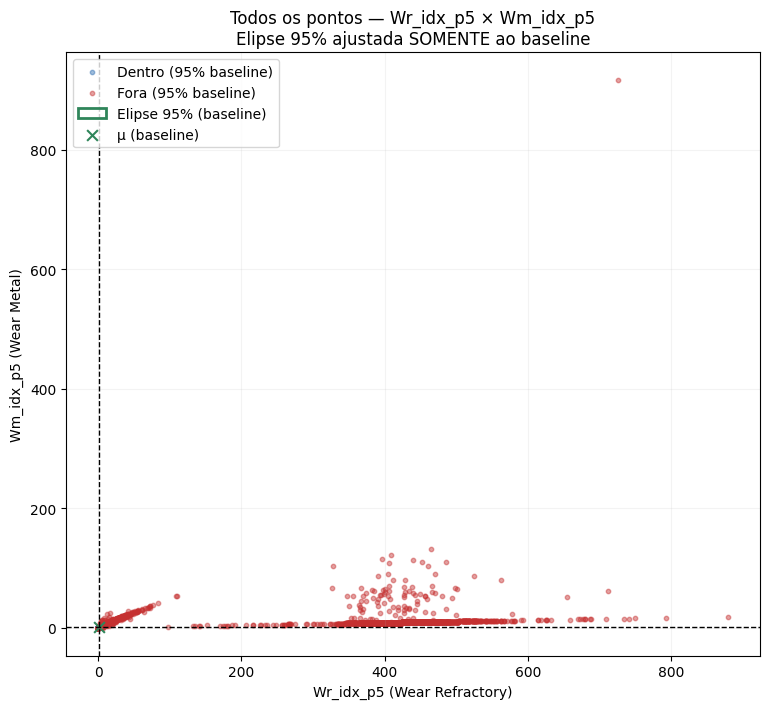

Figura salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\relatorio\capitulo_09\figs\fig_9_2_scatter_todos_com_elipse_baseline.png


In [6]:
# -*- coding: utf-8 -*-
# Scatter de TODOS os pontos com elipse 95% CALCULADA SOMENTE NO BASELINE
# e distribuição por quadrantes dos pontos FORA da elipse.

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

OUT_DIR    = os.path.join(BASE_DIR, r"relatorio\capitulo_09\figs")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PNG    = os.path.join(OUT_DIR, "fig_9_2_scatter_todos_com_elipse_baseline.png")

CHI2_95 = chi2.ppf(0.95, df=2)  # 5.991...

# ===== Helpers =====
def smart_parse_series(s: pd.Series):
    """Converte timestamp (string/numérico) em datetime quando possível; caso contrário retorna índice."""
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        xmin, xmax = float(np.nanmin(x)), float(np.nanmax(x))
        # Excel days
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.Timestamp("1899-12-30"); return base + pd.to_timedelta(x, unit="D")
        # epoch ms
        if 1e11 < xmin < 1e15 and 1e11 < xmax < 1e15:
            return pd.to_datetime(x, unit="ms", errors="coerce")
        # epoch s
        if 9e8 < xmin < 2e9 and 9e8 < xmax < 2e9:
            return pd.to_datetime(x, unit="s", errors="coerce")
    return pd.RangeIndex(len(s))

def smart_parse_ts_value(v):
    """Converte único valor (start/end) do JSON em Timestamp seguro."""
    if isinstance(v, (int,float)) and np.isfinite(v):
        x = float(v)
        if 30000 < x < 90000:  # Excel days
            base = pd.Timestamp("1899-12-30"); return base + pd.to_timedelta(int(x), unit="D")
        if 1e11 < x < 1e15:    # epoch ms
            return pd.to_datetime(int(x), unit="ms", errors="coerce")
        if 9e8 < x < 2e9:      # epoch s
            return pd.to_datetime(int(x), unit="s", errors="coerce")
        if 1970 <= x <= 2100:
            try: return pd.Timestamp(int(x), 1, 1)
            except: return None
        return None
    if isinstance(v, str):
        try: return pd.to_datetime(v, errors="coerce")
        except: return None
    return None

def find_period_bounds_safe(ref_obj):
    """Procura chaves start/end no JSON (variações) e converte com segurança."""
    def deep_find(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys):
                    ts = smart_parse_ts_value(v)
                    if ts is not None: return ts
                r = deep_find(v, keys)
                if r is not None: return r
        elif isinstance(d, list):
            for it in d:
                r = deep_find(it, keys)
                if r is not None: return r
        return None
    t0 = deep_find(ref_obj, ["start","inicio","t_start","t0","ini"])
    t1 = deep_find(ref_obj, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== Carga =====
df = pd.read_csv(DADOS_REF)
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")

df["_ts"] = smart_parse_series(df["timestamp"])
df = df.sort_values("_ts")

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds_safe(ref)
if b0 is None or b1 is None:
    raise RuntimeError("Limites do baseline (start/end) não encontrados/parsáveis no JSON.")
if b0 > b1:
    b0, b1 = b1, b0

# ===== Garantir índices (se já existem, usar; senão calcular via p5 do baseline) =====
have_wrr = "wr/wrref" in df.columns
have_wmr = "wm/wmref" in df.columns
if not (have_wrr and have_wmr):
    if "wr_kg_m2_h" not in df.columns or "wm_kg_m2_h" not in df.columns:
        raise RuntimeError("Faltam 'wr/wrref'/'wm/wmref' e também 'wr_kg_m2_h'/'wm_kg_m2_h' para calcular.")
    mask_ref = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
    ref_slice = df.loc[mask_ref]
    if ref_slice.empty:
        raise RuntimeError("Baseline vazio no CSV. Não é possível calcular índices por p5 do baseline.")
    wr_ref = float(np.nanpercentile(ref_slice["wr_kg_m2_h"], 5))
    wm_ref = float(np.nanpercentile(ref_slice["wm_kg_m2_h"], 5))
    if not have_wrr: df["wr/wrref"] = df["wr_kg_m2_h"] / wr_ref
    if not have_wmr: df["wm/wmref"] = df["wm_kg_m2_h"] / wm_ref

# ===== 1) Parâmetros da ELIPSE a partir do BASELINE =====
mask_baseline = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
dfb = df.loc[mask_baseline, ["wr/wrref","wm/wmref"]].replace([np.inf,-np.inf], np.nan).dropna()
if dfb.empty:
    raise RuntimeError("Não há dados válidos de wr/wrref e wm/wmref no baseline para ajustar a elipse.")

xb = dfb["wr/wrref"].values
yb = dfb["wm/wmref"].values
B  = np.vstack([xb, yb])          # 2 x n
mu = np.nanmean(B, axis=1)        # média 2D (baseline)
S  = np.cov(B)                    # 2x2 cov (baseline)
# robustez PD
eigvals = np.linalg.eigvals(S)
if not np.all(eigvals > 1e-12):
    S = S + 1e-6*np.eye(2)

# Pré-cálculos para elipse
L, U = np.linalg.eigh(S)          # S = U diag(L) U^T (baseline)
axes = np.sqrt(CHI2_95 * L)       # raios
theta = np.degrees(np.arctan2(U[1,1], U[0,1]))  # ângulo do maior autovetor (ordenação abaixo)

# Ordenar por autovalor decrescente (apenas para desenhar width>height)
order = np.argsort(L)[::-1]
L, U = L[order], U[:, order]
axes = axes[order]
theta = np.degrees(np.arctan2(U[1,0], U[0,0]))

# ===== 2) Classificar TODOS os pontos com base na elipse do baseline =====
full = df[["wr/wrref","wm/wmref"]].replace([np.inf,-np.inf], np.nan).dropna()
X = full.values  # n x 2
Sinv = np.linalg.inv(S)
d2 = np.einsum("ij,ji->i", (X - mu) @ Sinv, (X - mu).T)  # distâncias de Mahalanobis^2
inside = d2 <= CHI2_95

pct_inside  = 100.0 * np.mean(inside)
pct_outside = 100.0 - pct_inside

# ===== 3) Distribuição por quadrantes (apenas FORA) =====
def quadrant(xi, yi):
    if xi > 1 and yi > 1:   return "Q1 (>1,>1)"
    if xi > 1 and yi <= 1:  return "Q2 (>1,≤1)"
    if xi <= 1 and yi > 1:  return "Q3 (≤1,>1)"
    return "Q4 (≤1,≤1)"

full_out = full.loc[~inside]
quad_counts = full_out.apply(lambda s: quadrant(s["wr/wrref"], s["wm/wmref"]), axis=1).value_counts()
quad_pct = (100.0 * quad_counts / max(1, len(full_out))).round(2)

print(f"Total de pontos (todos): {len(full)}")
print(f"Dentro da elipse (baseline 95%): {pct_inside:.2f}%")
print(f"Fora da elipse: {pct_outside:.2f}%")
print("\nDistribuição dos FORA por quadrante:")
print(quad_pct.to_string())

# ===== 4) Plot =====
fig, ax = plt.subplots(figsize=(7.8, 7.2))

# plotar todos (dentro/fora)
ax.scatter(full.loc[inside, "wr/wrref"], full.loc[inside, "wm/wmref"],
           s=10, color="#2b6cb0", alpha=0.45, label="Dentro (95% baseline)")
ax.scatter(full.loc[~inside, "wr/wrref"], full.loc[~inside, "wm/wmref"],
           s=10, color="#c53030", alpha=0.45, label="Fora (95% baseline)")

# linhas guias
ax.axhline(1.0, color="black", linestyle="--", lw=1)
ax.axvline(1.0, color="black", linestyle="--", lw=1)

# elipse (baseline)
width, height = 2*axes[0], 2*axes[1]
ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta,
                  edgecolor="#2f855a", facecolor="none", lw=2, label="Elipse 95% (baseline)")
ax.add_patch(ellipse)

# centro
ax.scatter([mu[0]], [mu[1]], marker="x", s=60, color="#2f855a", label="μ (baseline)")

ax.set_xlabel("Wr_idx_p5 (Wear Refractory)")
ax.set_ylabel("Wm_idx_p5 (Wear Metal)")
ax.set_title("Todos os pontos — Wr_idx_p5 × Wm_idx_p5\nElipse 95% ajustada SOMENTE ao baseline")
ax.legend(loc="upper left")
ax.grid(alpha=0.15)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=160)
plt.show()

print("Figura salva em:", OUT_PNG)


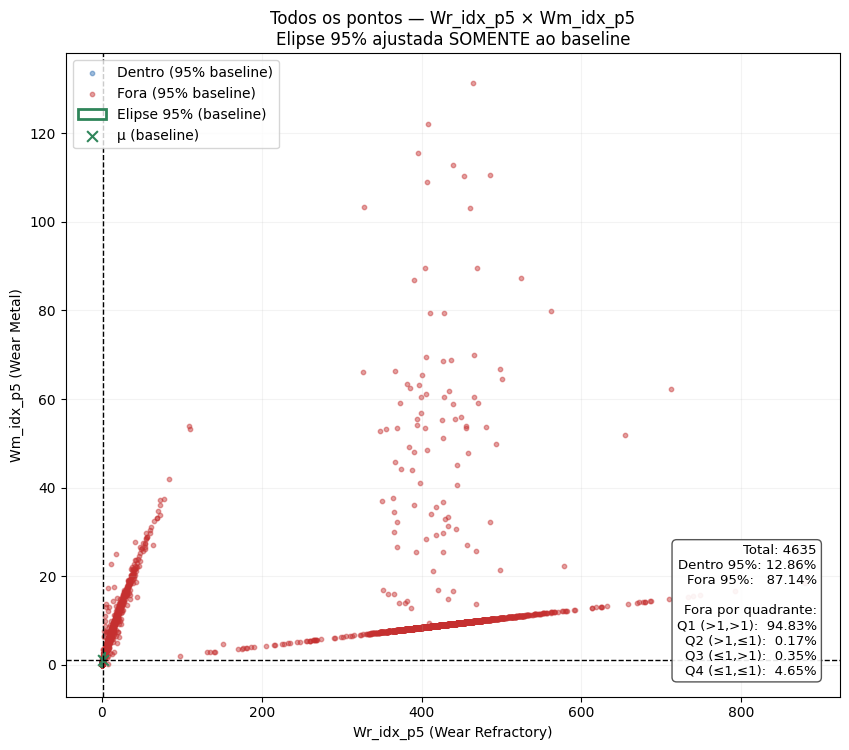

Figura salva em: C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO\relatorio\capitulo_09\figs\fig_9_2_scatter_todos_com_elipse_baseline_tabela.png


In [7]:
# -*- coding: utf-8 -*-
# TODOS os pontos com elipse 95% (ajustada SOMENTE ao baseline) + tabela interna
# Exclui 1 ponto extremo em Y (maior wm/wmref) antes da análise

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# ===== CONFIG =====
BASE_DIR   = r"C:\Users\wilso\MBA_EMPREENDEDORISMO\3AGD\A1_LOCAL_REFAZIMENTO"
FREEZE_DIR = os.path.join(BASE_DIR, r"outputs\freeze\v1_20250818_0635")
REF_JSON   = os.path.join(FREEZE_DIR, r"reference_selection\reference_period.json")
DADOS_REF  = os.path.join(FREEZE_DIR, r"reference_selection\dados_ref.csv")

OUT_DIR    = os.path.join(BASE_DIR, r"relatorio\capitulo_09\figs")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PNG    = os.path.join(OUT_DIR, "fig_9_2_scatter_todos_com_elipse_baseline_tabela.png")

CHI2_95 = chi2.ppf(0.95, df=2)  # 5.991...
DROP_TOP_Y_OUTLIER = True       # remove o maior y (wm/wmref) antes de classificar

# ===== Helpers =====
def smart_parse_series(s: pd.Series):
    if np.issubdtype(s.dtype, np.datetime64):
        return s
    if s.dtype == object:
        ts = pd.to_datetime(s, errors="coerce")
        if ts.notna().mean() > 0.8: return ts
        ts = pd.to_datetime(s, errors="coerce", dayfirst=True)
        if ts.notna().mean() > 0.8: return ts
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        xmin, xmax = float(np.nanmin(x)), float(np.nanmax(x))
        if 30000 < xmin < 90000 and 30000 < xmax < 90000:
            base = pd.Timestamp("1899-12-30"); return base + pd.to_datetime(x, unit="D", errors="coerce") - pd.Timestamp("1970-01-01")
        if 1e11 < xmin < 1e15 and 1e11 < xmax < 1e15:
            return pd.to_datetime(x, unit="ms", errors="coerce")
        if 9e8 < xmin < 2e9 and 9e8 < xmax < 2e9:
            return pd.to_datetime(x, unit="s", errors="coerce")
    return pd.RangeIndex(len(s))

def smart_parse_ts_value(v):
    if isinstance(v, (int,float)) and np.isfinite(v):
        x = float(v)
        if 30000 < x < 90000:
            base = pd.Timestamp("1899-12-30"); return base + pd.to_timedelta(int(x), unit="D")
        if 1e11 < x < 1e15: return pd.to_datetime(int(x), unit="ms", errors="coerce")
        if 9e8 < x < 2e9:   return pd.to_datetime(int(x), unit="s", errors="coerce")
        if 1970 <= x <= 2100:
            try: return pd.Timestamp(int(x), 1, 1)
            except: return None
        return None
    if isinstance(v, str):
        try: return pd.to_datetime(v, errors="coerce")
        except: return None
    return None

def find_period_bounds_safe(ref_obj):
    def deep_find(d, keys):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(k, str) and any(kk in k.lower() for kk in keys):
                    ts = smart_parse_ts_value(v)
                    if ts is not None: return ts
                r = deep_find(v, keys)
                if r is not None: return r
        elif isinstance(d, list):
            for it in d:
                r = deep_find(it, keys)
                if r is not None: return r
        return None
    t0 = deep_find(ref_obj, ["start","inicio","t_start","t0","ini"])
    t1 = deep_find(ref_obj, ["end","fim","t_end","t1","final"])
    return t0, t1

# ===== Carga e preparação =====
df = pd.read_csv(DADOS_REF)
if "timestamp" not in df.columns:
    raise RuntimeError("A coluna 'timestamp' não está no dados_ref.csv.")
df["_ts"] = smart_parse_series(df["timestamp"])
df = df.sort_values("_ts")

with open(REF_JSON, "r", encoding="utf-8") as f:
    ref = json.load(f)
b0, b1 = find_period_bounds_safe(ref)
if b0 is None or b1 is None:
    raise RuntimeError("Limites do baseline (start/end) não encontrados/parsáveis no JSON.")
if b0 > b1: b0, b1 = b1, b0

# Índices
if "wr/wrref" not in df.columns or "wm/wmref" not in df.columns:
    raise RuntimeError("O CSV precisa conter 'wr/wrref' e 'wm/wmref' para este fluxo.")

# ===== Elipse do baseline (μ, Σ) =====
mask_baseline = (df["_ts"] >= pd.Timestamp(b0)) & (df["_ts"] <= pd.Timestamp(b1))
dfb = df.loc[mask_baseline, ["wr/wrref","wm/wmref"]].replace([np.inf,-np.inf], np.nan).dropna()
if dfb.empty:
    raise RuntimeError("Baseline sem pontos válidos de wr/wrref e wm/wmref.")

B  = dfb[["wr/wrref","wm/wmref"]].to_numpy()
mu = B.mean(axis=0)
S  = np.cov(B, rowvar=False)
# robustez PD
eigvals = np.linalg.eigvals(S)
if not np.all(eigvals > 1e-12):
    S = S + 1e-6*np.eye(2)

# Pré-cálculo para desenho da elipse
L, U = np.linalg.eigh(S)          # S = U diag(L) U^T
order = np.argsort(L)[::-1]
L, U = L[order], U[:, order]
axes = np.sqrt(CHI2_95 * L)       # raios (a,b)
theta = np.degrees(np.arctan2(U[1,0], U[0,0]))

# ===== Todos os pontos (removendo 1 outlier de Y, se habilitado) =====
full = df[["wr/wrref","wm/wmref"]].replace([np.inf,-np.inf], np.nan).dropna().copy()

if DROP_TOP_Y_OUTLIER and len(full) > 0:
    idx_max_y = full["wm/wmref"].idxmax()
    full = full.drop(index=idx_max_y)

X = full.to_numpy()
Sinv = np.linalg.inv(S)
d2 = np.einsum("ij,ji->i", (X - mu) @ Sinv, (X - mu).T)
inside = d2 <= CHI2_95

total_pts   = len(full)
pct_inside  = 100.0 * np.mean(inside)
pct_outside = 100.0 - pct_inside

# ===== Quadrantes dos FORA =====
def quadrant(xi, yi):
    if xi > 1 and yi > 1:   return "Q1 (>1,>1)"
    if xi > 1 and yi <= 1:  return "Q2 (>1,≤1)"
    if xi <= 1 and yi > 1:  return "Q3 (≤1,>1)"
    return "Q4 (≤1,≤1)"

full_out = full.loc[~inside]
quad_counts = full_out.apply(lambda s: quadrant(s["wr/wrref"], s["wm/wmref"]), axis=1).value_counts()
quad_pct = (100.0 * quad_counts / max(1, len(full_out))).round(2)

# ===== Plot =====
fig, ax = plt.subplots(figsize=(8.6, 7.6))

# pontos
ax.scatter(full.loc[inside, "wr/wrref"], full.loc[inside, "wm/wmref"],
           s=10, color="#2b6cb0", alpha=0.45, label="Dentro (95% baseline)")
ax.scatter(full.loc[~inside, "wr/wrref"], full.loc[~inside, "wm/wmref"],
           s=10, color="#c53030", alpha=0.45, label="Fora (95% baseline)")

# linhas guia
ax.axhline(1.0, color="black", linestyle="--", lw=1)
ax.axvline(1.0, color="black", linestyle="--", lw=1)

# elipse
width, height = 2*axes[0], 2*axes[1]
ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta,
                  edgecolor="#2f855a", facecolor="none", lw=2, label="Elipse 95% (baseline)")
ax.add_patch(ellipse)

# centro
ax.scatter([mu[0]], [mu[1]], marker="x", s=60, color="#2f855a", label="μ (baseline)")

ax.set_xlabel("Wr_idx_p5 (Wear Refractory)")
ax.set_ylabel("Wm_idx_p5 (Wear Metal)")
ax.set_title("Todos os pontos — Wr_idx_p5 × Wm_idx_p5\nElipse 95% ajustada SOMENTE ao baseline")
ax.grid(alpha=0.15)
ax.legend(loc="upper left")

# ===== Tabela interna =====
# Monta texto com os percentuais e quadrantes
lines = [
    f"Total: {total_pts}",
    f"Dentro 95%: {pct_inside:.2f}%",
    f"Fora 95%:   {pct_outside:.2f}%",
    "",
    "Fora por quadrante:",
    f"Q1 (>1,>1):  {quad_pct.get('Q1 (>1,>1)', 0.0):.2f}%",
    f"Q2 (>1,≤1):  {quad_pct.get('Q2 (>1,≤1)', 0.0):.2f}%",
    f"Q3 (≤1,>1):  {quad_pct.get('Q3 (≤1,>1)', 0.0):.2f}%",
    f"Q4 (≤1,≤1):  {quad_pct.get('Q4 (≤1,≤1)', 0.0):.2f}%"
]
textbox = "\n".join(lines)

# coloca a caixa no canto inferior direito (ajuste x/y conforme layout)
ax.text(0.97, 0.03, textbox,
        transform=ax.transAxes,
        fontsize=9.5, va="bottom", ha="right",
        bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.9, edgecolor="#444"))

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=180)
plt.show()

print("Figura salva em:", OUT_PNG)
